In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import itertools
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('brown')
nltk.download('stopwords')
stopwords = stopwords.words('english')

bool_train = True

[nltk_data] Downloading package brown to /Users/r0g06z5/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/r0g06z5/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Representations

When we think of approaches to find word representations, we can classify them coming from either of the two methods:
1. **Learning based:**
    1. Word2Vec embeddings: learns by maximizing probability of context (target) words given target (context) word
        1. CBOW (Continuous bag of words) - predict target word given context words
        2. SkipGram - predict context words given target word
    2. ELMo (Embeddings from Language Model) embeddings - word embeddings derived from Language Modelling (the fundamental task of NLP)
    3. BERT embeddings (word/sentence) and more..
2. **Statistics based:** Uses global count statistics to generate word representations 
    1. LSA (Latent Semantic Analysis) - dimensional reduction (SVD) on term document matrix 
    2. LDA (Latent Dirichlet Allocation) - builds statistical model to discover topics over range of documents

However, the good part of Word2Vec embeddings is its ability to preserve semantic and syntatic relationships while performing linear arithmetic operations over word vectors (For example - King - Man + Women --> Queen). 

So, can we build vector embeddings that combine the global count statistics and preserve such relationships? 

Yes, with GLoVe embeddings.

### GLoVe embeddings

GLoVe embeddings builds co-occurence matrix that highlights conditional probabilities of words occuring together given a context word. The original [paper](https://nlp.stanford.edu/pubs/glove.pdf) explains how ratio of such conditional probabilities have potential to encode some form of word meanings. 

The paper derives the function $F$ that maps a relation between word vectors to conditional probability:

\begin{equation}
F\left(w_{i}, w_{j}, \tilde{w}_{k}\right)=\frac{P_{i k}}{P_{j k}}
\end{equation}

which eventually resolves to this

\begin{equation}
w_{i}^{T} \tilde{w}_{k}+b_{i}+\tilde{b}_{k}=\log \left(X_{i k}\right)
\end{equation}

modelling it as a regression problem, with the least-squares objective:

\begin{equation}
J=\sum_{i, j=1}^{V} f\left(X_{i j}\right)\left(w_{i}^{T} \tilde{w}_{j}+b_{i}+\tilde{b}_{j}-\log X_{i j}\right)^{2}
\end{equation}

Our interest is to find the optimized word vectors as a result of minimizing the least-squares objective (loss function). We solve this problem by optimizing weights and biases using Gradient Descent. We take a small sample of data to layout the code due to limited computational resources, and finally visualize the word vectors in 2D and with similarities.

In [2]:
# info

# number of training epochs
n_epochs = 4000

# tolerance
eps = 0.001

# number of sentences to consider
n_sents = 10

# weight embedding size
embedding_size = 20

# learning rate
alpha = 0.1

# AdaGrad parameter 
delta = 0.8

# context_window_size 
window_size = 5

# top N similar words
topN = 5

In [3]:
brown = nltk.corpus.brown
sents = brown.sents()[:n_sents]

print('Processing sentences..\n')
processed_sents = []
for sent in sents:
    processed_sents.append([word.lower() for word in sent if word.isalnum() and word not in stopwords])

tokens = list(set(list(itertools.chain(*processed_sents))))   
n_tokens = len(tokens)
print('Number of Sentences:', len(sents)) 
print('Number of Tokens:', n_tokens)

Processing sentences..

Number of Sentences: 10
Number of Tokens: 100


In [4]:
def get_co_occurences(token, processed_sents, window_size):
    co_occurences = []
    for sent in processed_sents:
        for idx in (np.array(sent)==token).nonzero()[0]:
            co_occurences.append(sent[max(0, idx-window_size):min(idx+window_size+1, len(sent))])

    co_occurences = list(itertools.chain(*co_occurences))
    co_occurence_idxs = list(map(lambda x: token2int[x], co_occurences))
    co_occurence_dict = Counter(co_occurence_idxs)
    co_occurence_dict = dict(sorted(co_occurence_dict.items()))
    return co_occurence_dict

def get_co_occurence_matrix(tokens, processed_sents, window_size):
    for token in tokens:
        token_idx = token2int[token]
        co_occurence_dict = get_co_occurences(token, processed_sents, window_size)
        co_occurence_matrix[token_idx, list(co_occurence_dict.keys())] = list(co_occurence_dict.values())
        
    np.fill_diagonal(co_occurence_matrix, 0)    
    return co_occurence_matrix

In [5]:
def f(X_wc, X_max, alpha):
    if X_wc<X_max:
        return (X_wc/X_max)**alpha
    else:
        return 1

def loss_fn(weights, bias, co_occurence_matrix, n_tokens, X_max, alpha):
    total_cost = 0
    for idx_word in range(n_tokens):
        for idx_context in range(n_tokens):
            w_word = weights[idx_word]
            w_context = weights[n_tokens+idx_context]
            b_word = bias[idx_word]
            b_context = bias[n_tokens+idx_context]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            total_cost += f(X_wc, X_max, alpha) * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))**2            
    return total_cost

def gradient(weights, bias, co_occurence_matrix, n_tokens, embedding_size, X_max, alpha):
    dw = np.zeros((2*n_tokens, embedding_size))
    db = np.zeros(2*n_tokens)

    # building word vectors
    for idx_word in range(n_tokens):
        w_word = weights[idx_word]
        b_word = bias[idx_word]

        for idx_context in range(n_tokens):
            w_context = weights[n_tokens+idx_context]
            b_context = bias[n_tokens+idx_context]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            value = f(X_wc, X_max, alpha) * 2 * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))
            db[idx_word] += value
            dw[idx_word] += value * w_context

    # building context vectors
    for idx_context in range(n_tokens):
        w_context = weights[n_tokens + idx_context]
        b_context = bias[n_tokens + idx_context]

        for idx_word in range(n_tokens):
            w_word = weights[idx_word]
            b_word = bias[idx_word]
            X_wc = co_occurence_matrix[idx_word, idx_context]
            value = f(X_wc, X_max, alpha) * 2 * (np.dot(w_word.T, w_context) + b_word + b_context - np.log(1 + X_wc))
            db[n_tokens + idx_context] += value
            dw[n_tokens + idx_context] += value * w_word
    return dw, db
            
def adagrad(weights_init, bias_init, n_epochs, alpha, eps, delta):
    weights = weights_init
    bias = bias_init
    r1 = np.zeros(weights.shape)
    r2 = np.zeros(bias.shape)    
    X_max = np.max(co_occurence_matrix)
    
    norm_grad_weights = []
    norm_grad_bias = []
    costs = []
    n_iter = 0
    cost = 1
    convergence = 1
    while cost>eps:
        dw, db = gradient(weights, bias, co_occurence_matrix, n_tokens, embedding_size, X_max, alpha)

        r1+=(dw)**2
        r2+=(db)**2
        weights -= np.multiply(alpha / (delta + np.sqrt(r1)), dw)
        bias -= np.multiply(alpha / (delta + np.sqrt(r2)), db)

        cost = loss_fn(weights, bias, co_occurence_matrix, n_tokens, X_max, alpha)

        if n_iter%200==0:
            print(f'Cost at {n_iter} iterations:', cost.round(3))
        
        norm_grad_weights.append(np.linalg.norm(dw))
        norm_grad_bias.append(np.linalg.norm(db))
        costs.append(cost)
        n_iter += 1
        
        if n_iter>=n_epochs:
            convergence = 0
            break
    
    if convergence:
        print(f'Converged in {len(costs)} epochs..')
    else:
        print(f'Training complete with {n_epochs} epochs..')
    return weights, bias, norm_grad_weights, norm_grad_bias, costs

In [6]:
def plotting(costs, last_n_epochs, norm_grad_weights, norm_grad_bias):
    plt.figure(figsize=(20,5))

    plt.subplot(131)
    plt.plot(costs[-last_n_epochs:], c='k')
    plt.title('cost')
    plt.xlabel('epochs')
    plt.ylabel('value')

    plt.subplot(132)
    plt.plot(norm_grad_weights[-last_n_epochs:], c='k')
    plt.title('norm_weights')
    plt.xlabel('epochs')
    plt.ylabel('value')

    plt.subplot(133)
    plt.plot(norm_grad_bias[-last_n_epochs:], c='k')
    plt.title('norm_bias')
    plt.xlabel('epochs')
    plt.ylabel('value')    
    plt.show()

In [7]:
def plotting_word_vectors(weights):
    pca = PCA(n_components = 2) 
    weights = pca.fit_transform(weights[:n_tokens])
    explained_var = (100 * sum(pca.explained_variance_)).round(2)
    print(f'Variance explained by 2 components: {explained_var}%')
    
    fig, ax = plt.subplots(figsize=(20,10))
    for word, x1, x2 in zip(tokens, weights[:,0], weights[:,1]):
        ax.annotate(word, (x1, x2))
        
    x_pad = 0.5
    y_pad = 1.5
    x_axis_min = np.amin(weights, axis=0)[0] - x_pad
    x_axis_max = np.amax(weights, axis=0)[0] + x_pad
    y_axis_min = np.amin(weights, axis=1)[1] - y_pad
    y_axis_max = np.amax(weights, axis=1)[1] + y_pad
    
    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

In [8]:
if bool_train:
    token2int = dict(zip(tokens, range(len(tokens))))
    int2token = {v:k for k,v in token2int.items()} 

    print('Building co-occurence matrix..')
    co_occurence_matrix = np.zeros(shape=(len(tokens), len(tokens)), dtype='int')
    co_occurence_matrix = get_co_occurence_matrix(tokens, processed_sents, window_size)
    print('Co-occurence matrix shape:', co_occurence_matrix.shape)
    assert co_occurence_matrix.shape == (n_tokens, n_tokens)

    # co-occurence matrix is similar
    assert np.all(co_occurence_matrix.T == co_occurence_matrix)

    print('\nTraining word vectors..')
    weights_init = np.random.random((2 * n_tokens, embedding_size))
    bias_init = np.random.random((2 * n_tokens,))
    weights, bias, norm_grad_weights, norm_grad_bias, costs = adagrad(weights_init, bias_init, n_epochs, alpha, eps, delta)

    # saving weights
    np.save('weights.npy', weights)

Building co-occurence matrix..
Co-occurence matrix shape: (100, 100)

Training word vectors..
Cost at 0 iterations: 9541.495
Cost at 200 iterations: 9.603
Cost at 400 iterations: 3.143
Cost at 600 iterations: 1.437
Cost at 800 iterations: 0.759
Cost at 1000 iterations: 0.43
Cost at 1200 iterations: 0.254
Cost at 1400 iterations: 0.155
Cost at 1600 iterations: 0.097
Cost at 1800 iterations: 0.062
Cost at 2000 iterations: 0.041
Cost at 2200 iterations: 0.028
Cost at 2400 iterations: 0.019
Cost at 2600 iterations: 0.013
Cost at 2800 iterations: 0.009
Cost at 3000 iterations: 0.007
Cost at 3200 iterations: 0.005
Cost at 3400 iterations: 0.004
Cost at 3600 iterations: 0.003
Cost at 3800 iterations: 0.002
Training complete with 4000 epochs..


In [27]:
def find_similar_words(csim, token, topN):
    token_idx = token2int[token]
    closest_words = list(map(lambda x: int2token[x], np.argsort(csim[token_idx])[::-1][:topN]))
    return closest_words

# getting cosine similarities between all combinations of word vectors
csim = cosine_similarity(weights[:n_tokens])

# masking diagonal values since they will be most similar
np.fill_diagonal(csim, 0)

token = 'court'
closest_words = find_similar_words(csim, token, topN)
print(f'Similar words to {token}:', closest_words)

Similar words to court: ['accepted', 'merger', 'recommended', 'presentments', 'charged']


Loading weights..
Plotting learning curves..


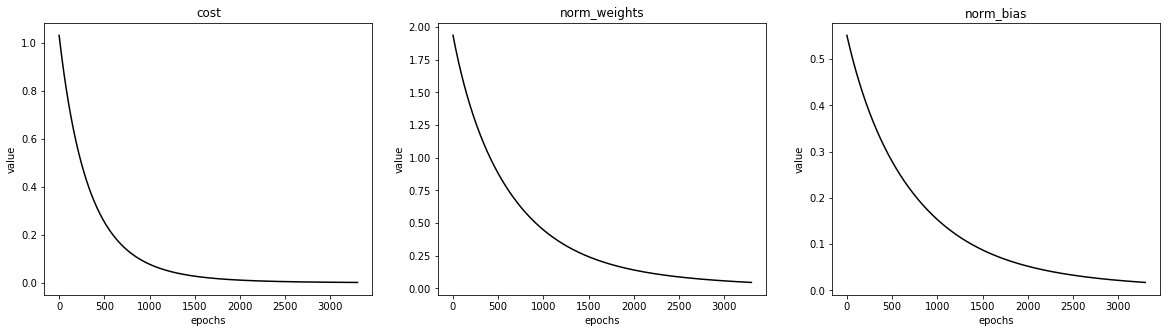

Plotting word vectors..
Variance explained by 2 components: 27.77%


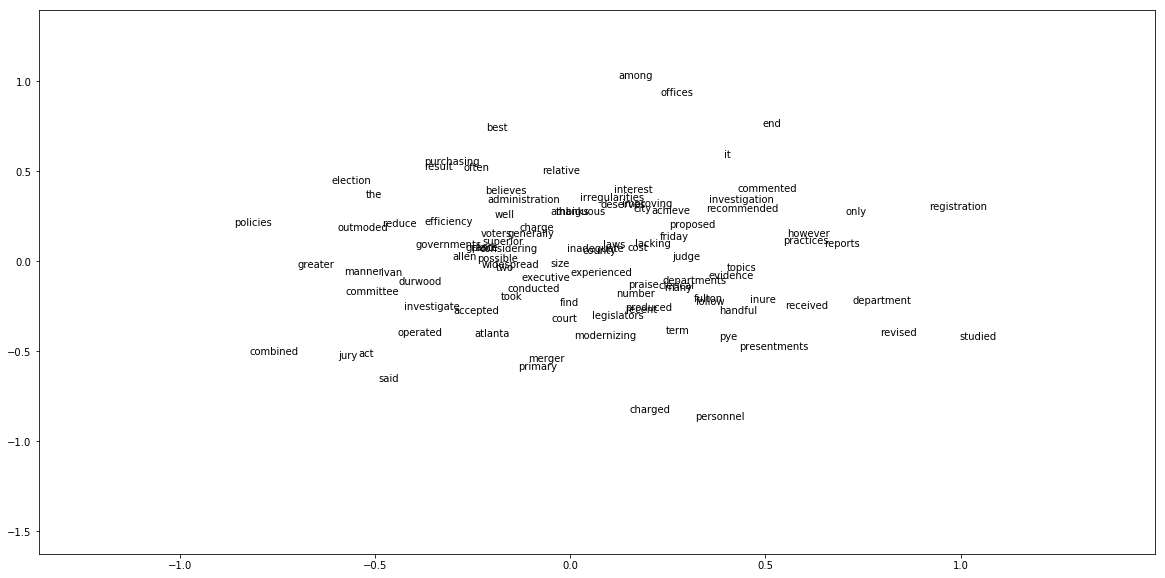

In [10]:
# loading pre-trained weights
print('Loading weights..')
loaded_weights = np.load('weights.npy', allow_pickle=True)

print('Plotting learning curves..')
last_n_epochs = 3300
plotting(costs, last_n_epochs, norm_grad_weights, norm_grad_bias)

print('Plotting word vectors..')
plotting_word_vectors(loaded_weights)